[Wstecz
Predict Visitor Purchases with a Classification Model in BigQuery ML](https://www.cloudskillsboost.google/focuses/1794?catalog_rank=%7B%22rank%22%3A1%2C%22num_filters%22%3A0%2C%22has_search%22%3Atrue%7D&parent=catalog&search_id=23687728)

In [ ]:
# https://www.cloudskillsboost.google/focuses/3528?parent=catalog

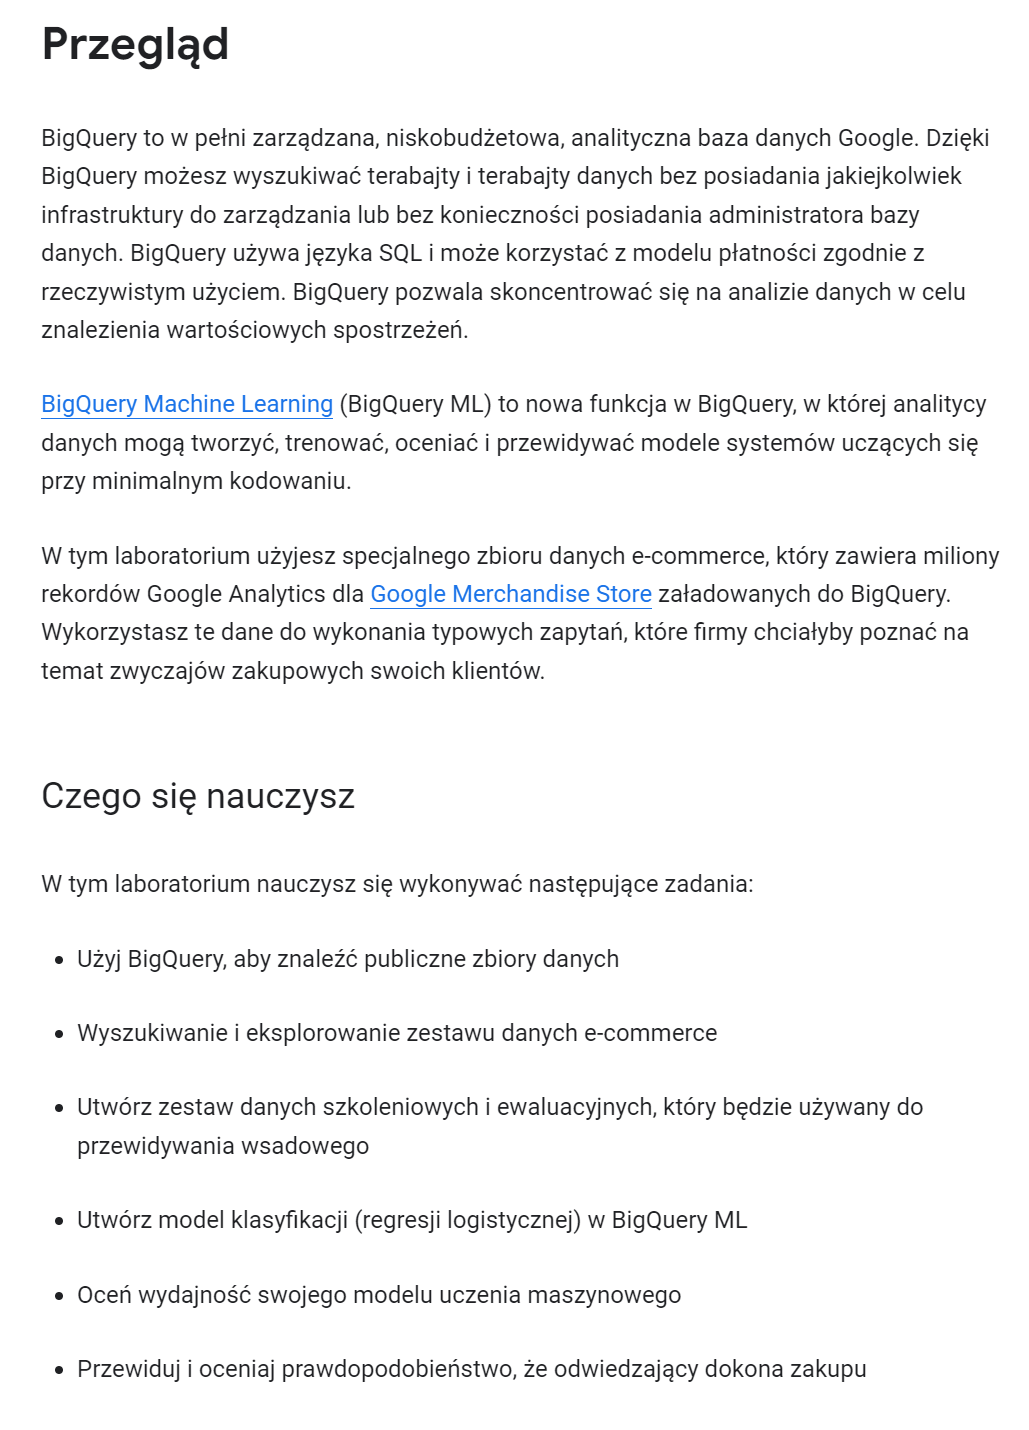

In [ ]:
# https://shop.googlemerchandisestore.com/

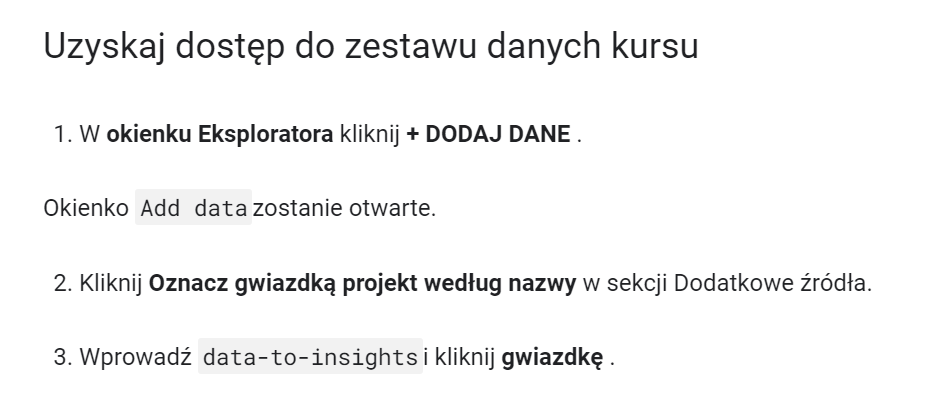

In [ ]:
# data-to-insights

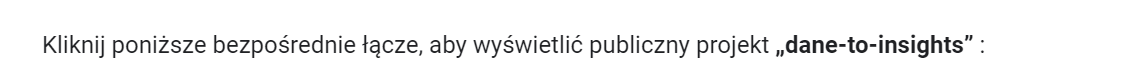

In [ ]:
https://console.cloud.google.com/bigquery?p=data-to-insights&d=ecommerce&t=web_analytics&page=table

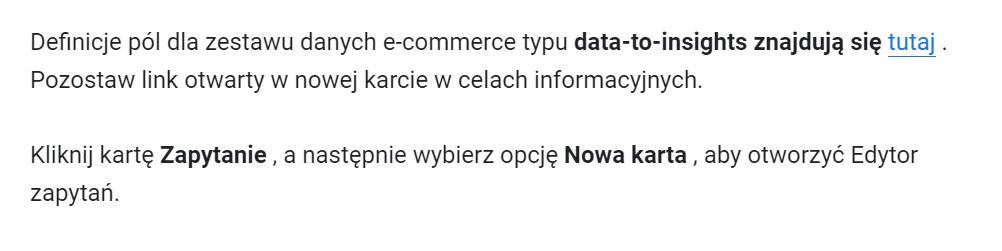

In [ ]:
# https://support.google.com/analytics/answer/3437719?hl=en

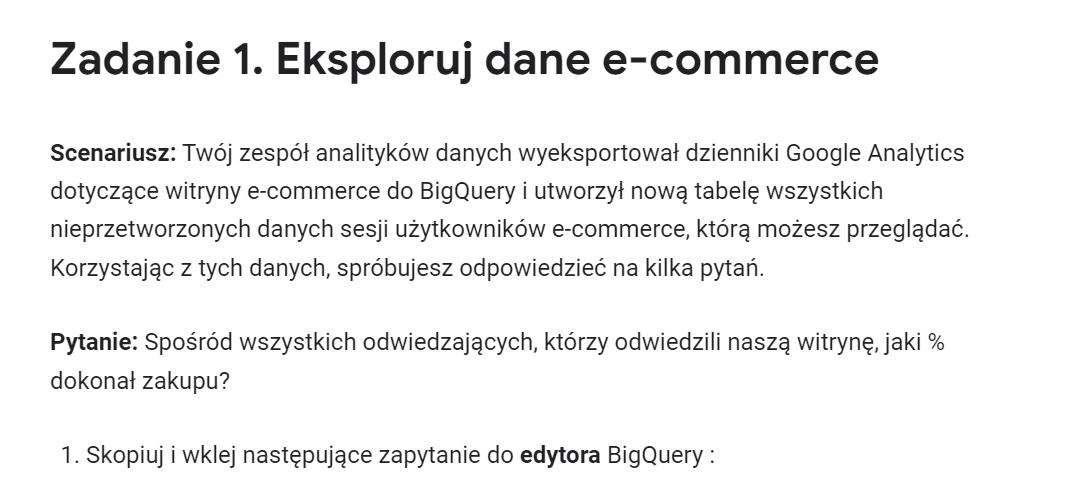

In [ ]:
%%bigquery

#standardSQL
WITH visitors AS (
SELECT
COUNT(DISTINCT fullVisitorId) AS total_visitors
FROM `data-to-insights.ecommerce.web_analytics`
),
purchasers AS(
SELECT
COUNT(DISTINCT fullVisitorId) AS total_purchasers
FROM `data-to-insights.ecommerce.web_analytics`
WHERE totals.transactions IS NOT NULL
)
SELECT
  total_visitors,
  total_purchasers,
  total_purchasers / total_visitors AS conversion_rate
FROM visitors, purchasers

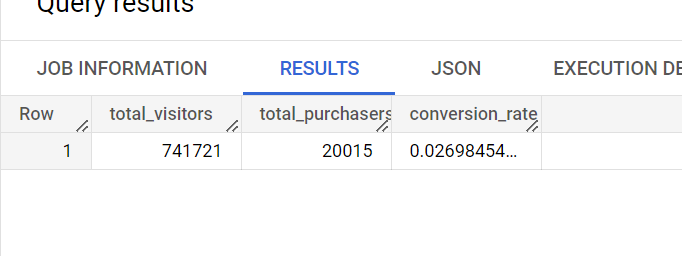

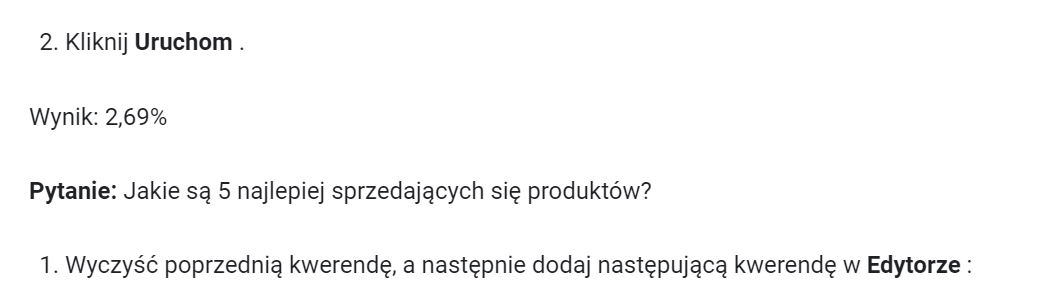

In [ ]:
%%bigquery

SELECT
  p.v2ProductName,
  p.v2ProductCategory,
  SUM(p.productQuantity) AS units_sold,
  ROUND(SUM(p.localProductRevenue/1000000),2) AS revenue
FROM `data-to-insights.ecommerce.web_analytics`,
UNNEST(hits) AS h,
UNNEST(h.product) AS p
GROUP BY 1, 2
ORDER BY revenue DESC
LIMIT 5;

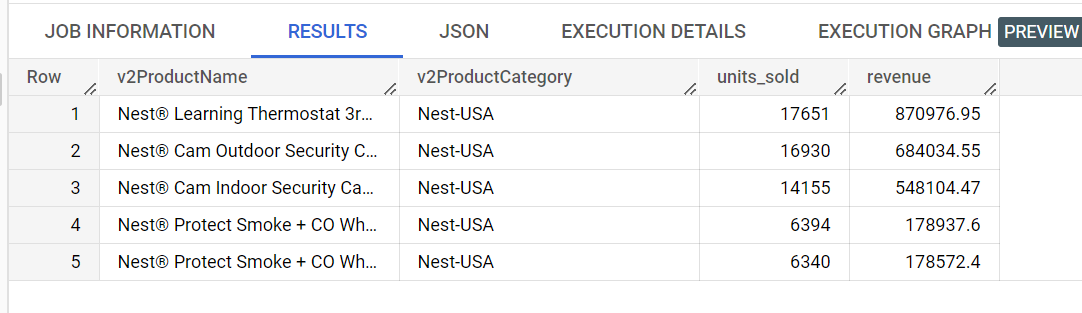

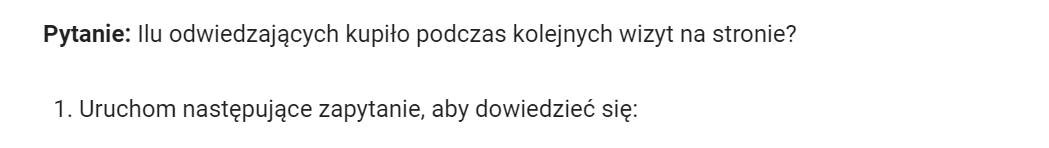

In [ ]:
%%bigquery

# visitors who bought on a return visit (could have bought on first as well
WITH all_visitor_stats AS (
SELECT
  fullvisitorid, # 741,721 unique visitors
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
SELECT
  COUNT(DISTINCT fullvisitorid) AS total_visitors,
  will_buy_on_return_visit
FROM all_visitor_stats
GROUP BY will_buy_on_return_visit

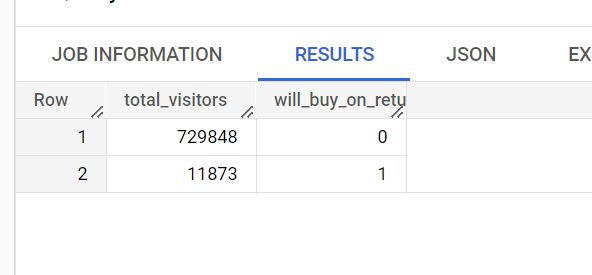

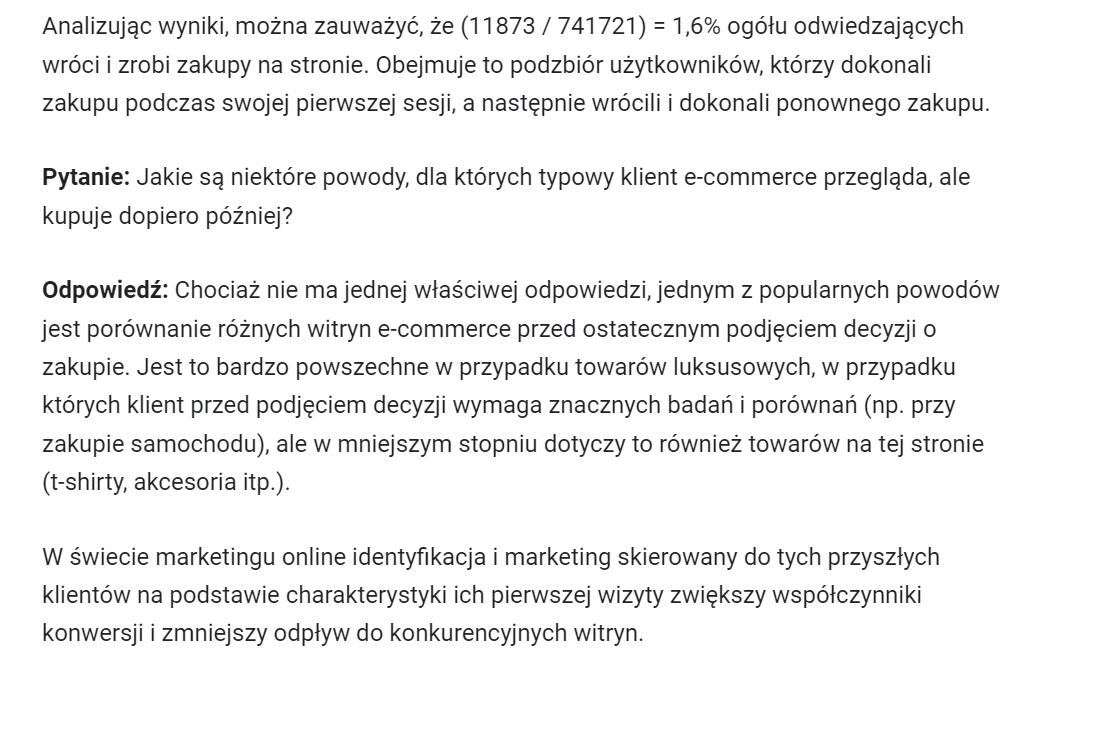

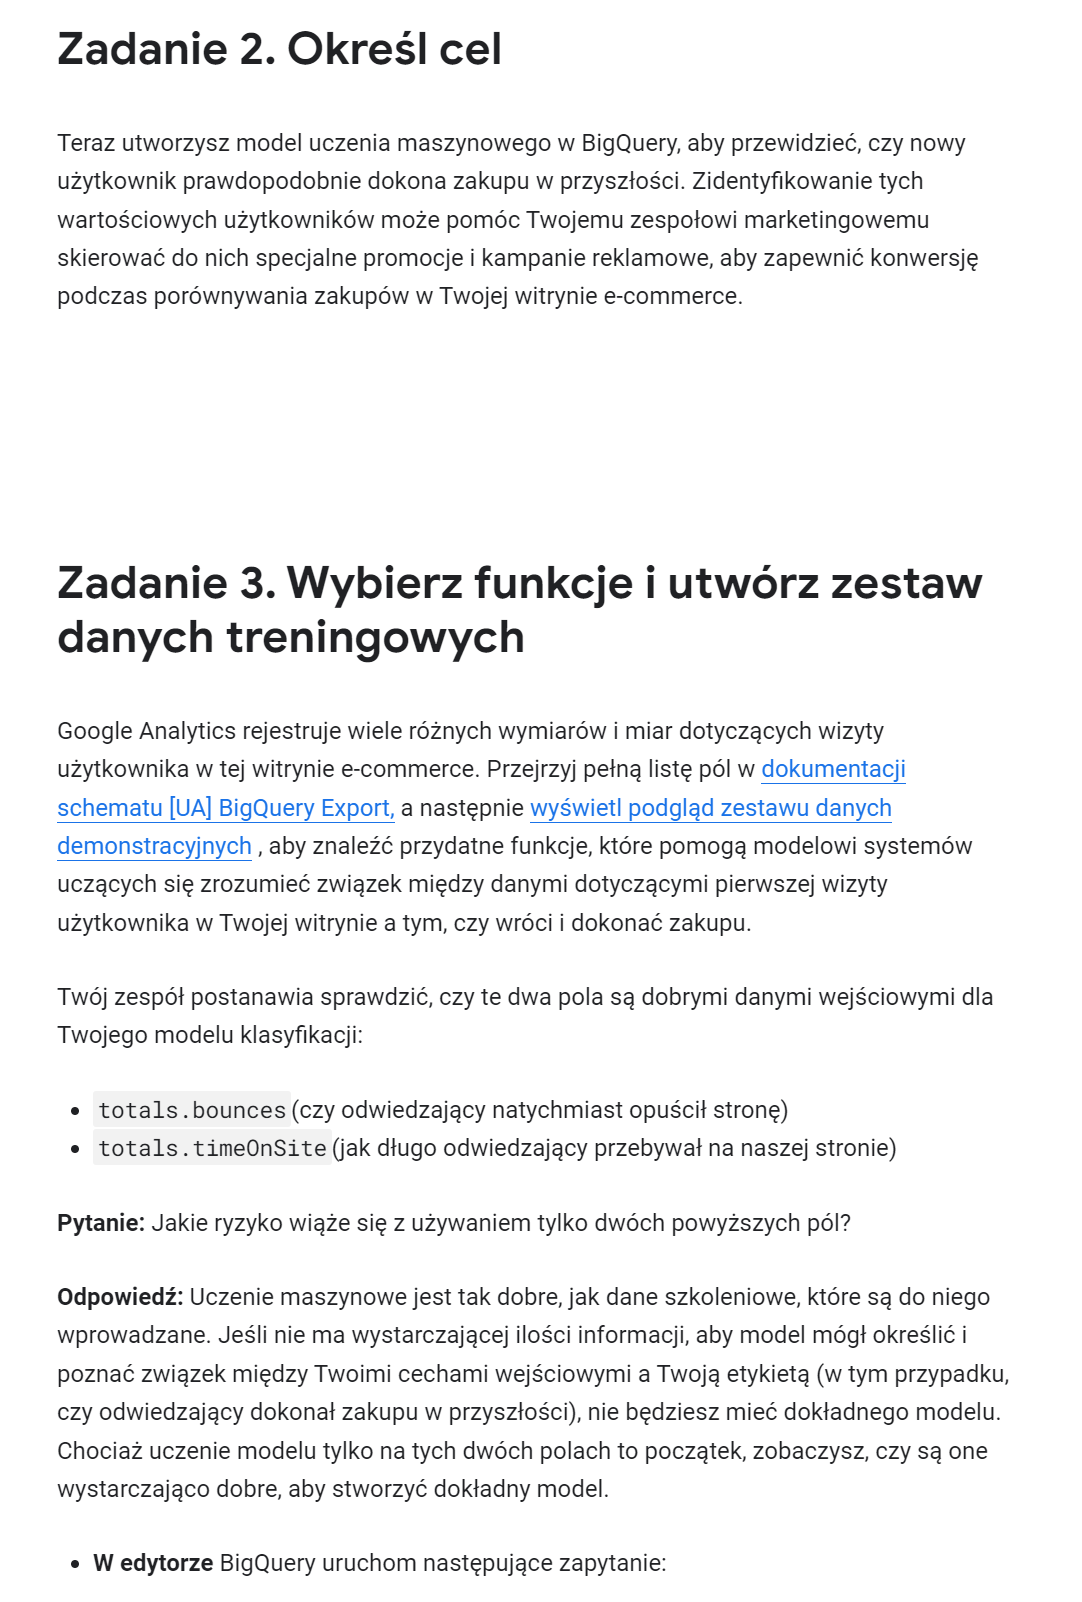

In [ ]:
%%bigquery

SELECT
  * EXCEPT(fullVisitorId)
FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1)
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
ORDER BY time_on_site DESC
LIMIT 10;

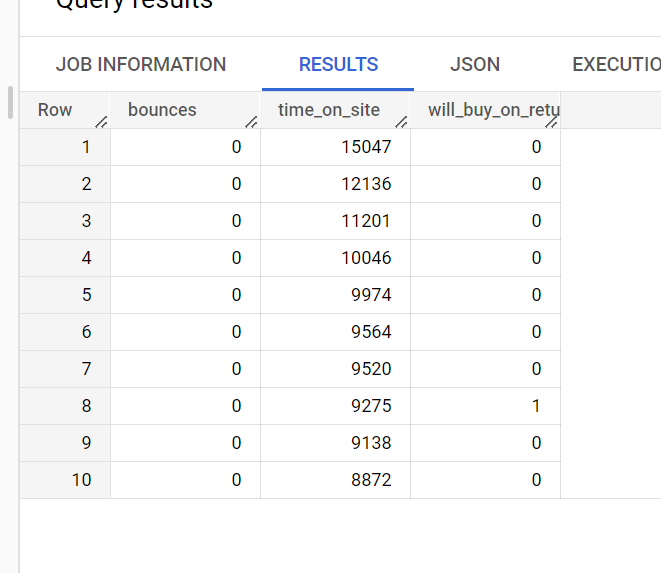

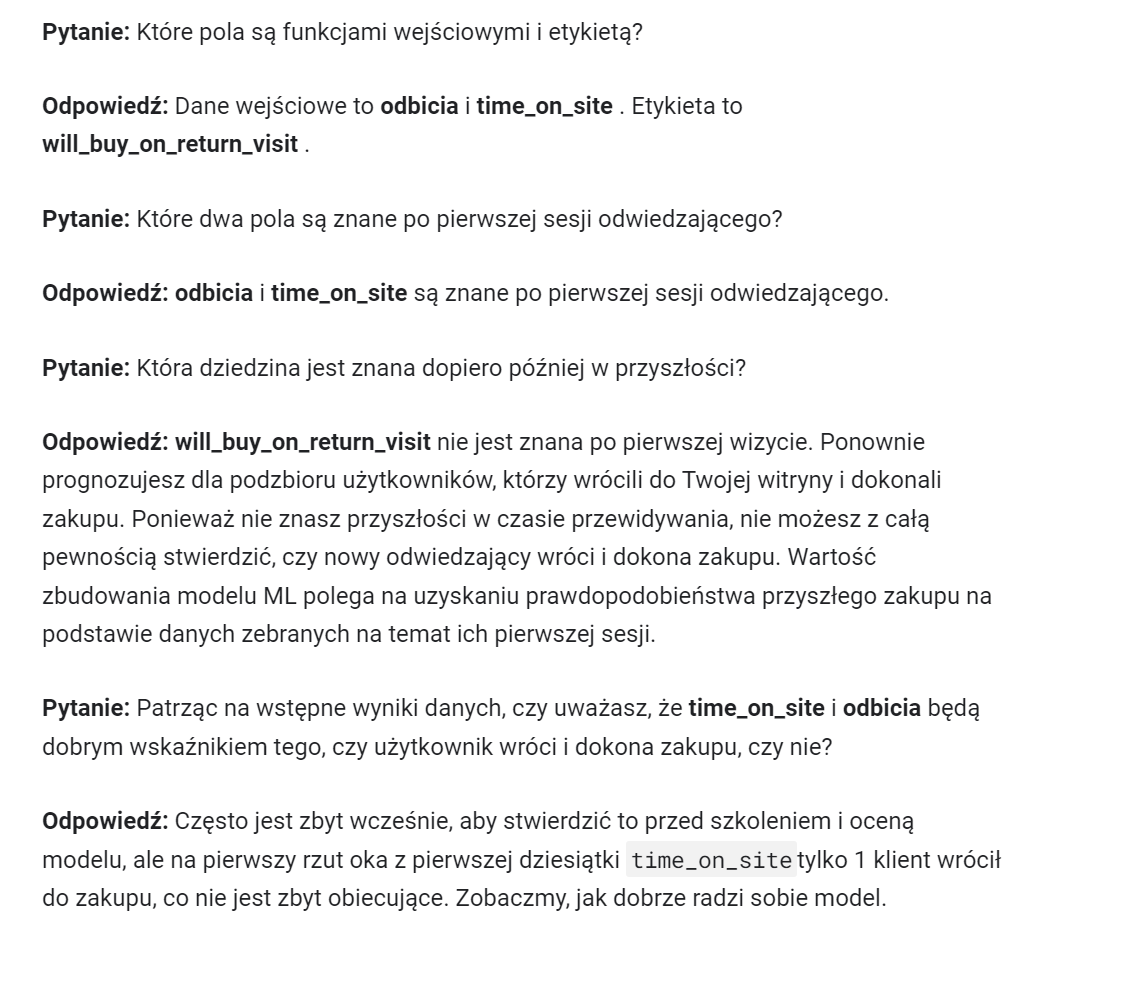

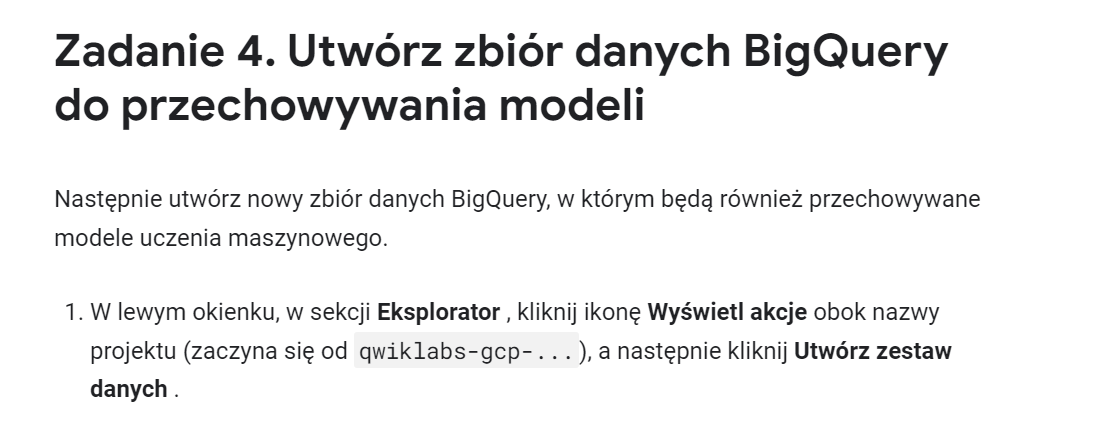

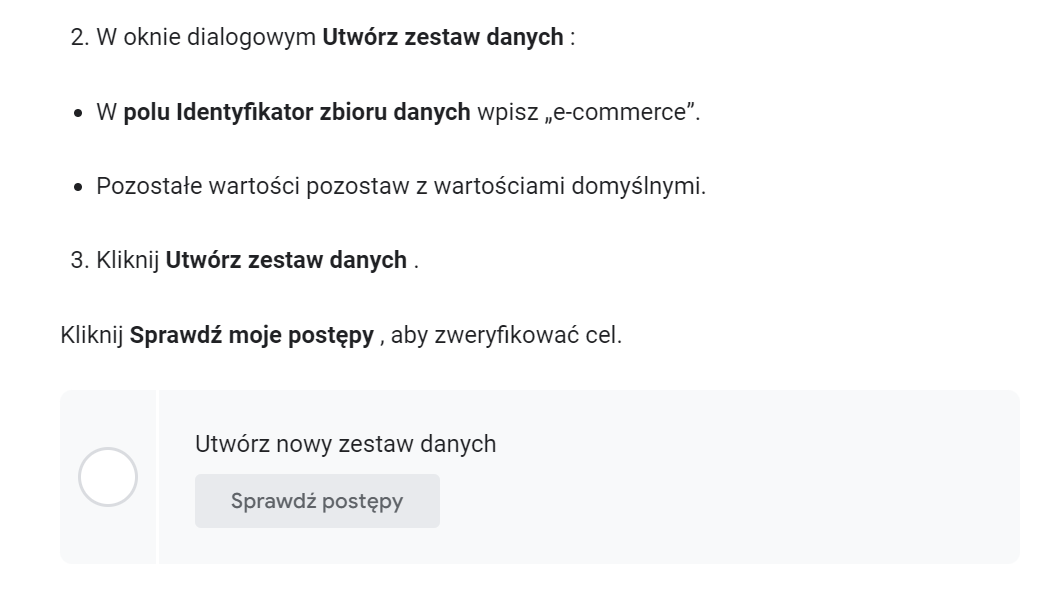

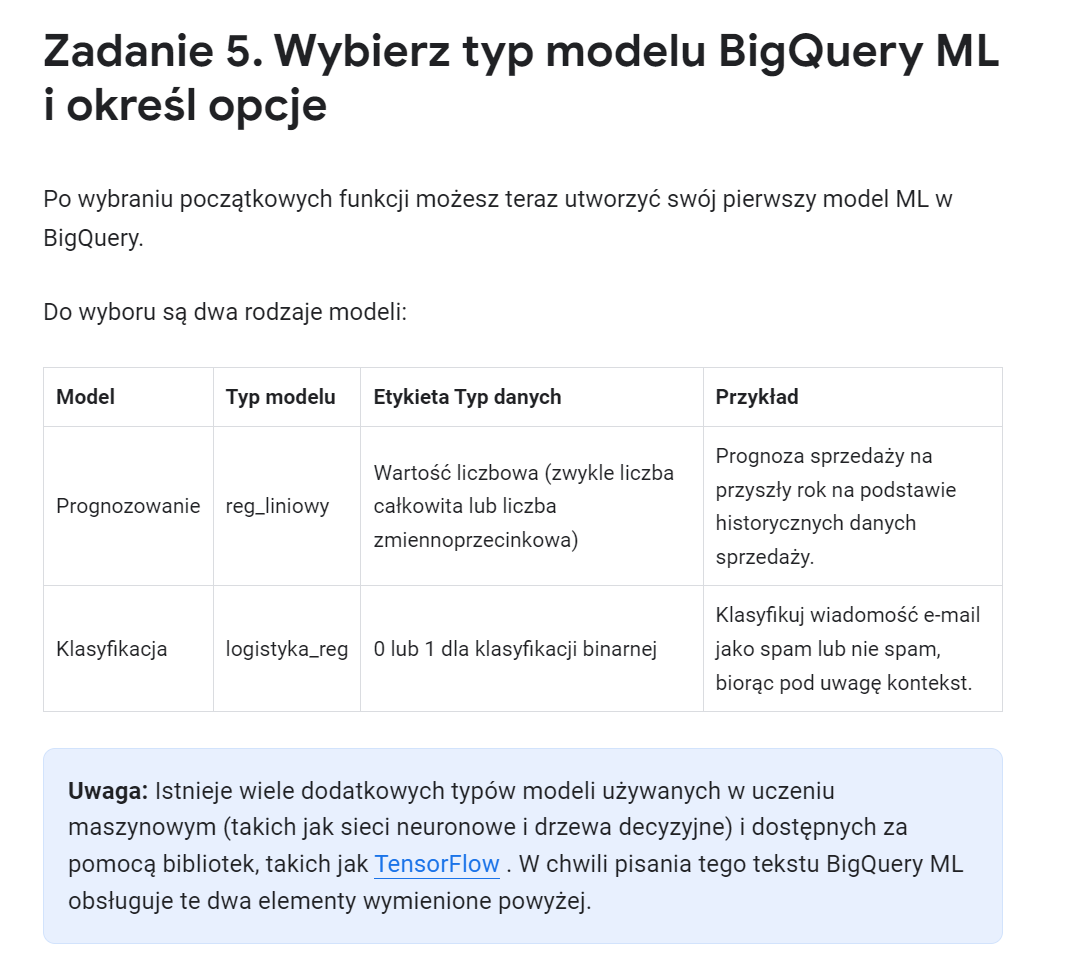

In [ ]:
# https://www.tensorflow.org/tutorials?hl=pl

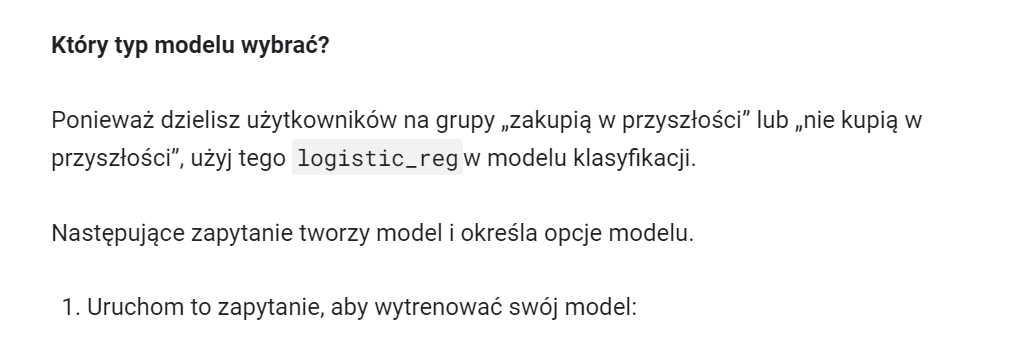

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `ecommerce.classification_model`
OPTIONS
(
model_type='logistic_reg',
labels = ['will_buy_on_return_visit']
)
AS
#standardSQL
SELECT
  * EXCEPT(fullVisitorId)
FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430') # train on first 9 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
;

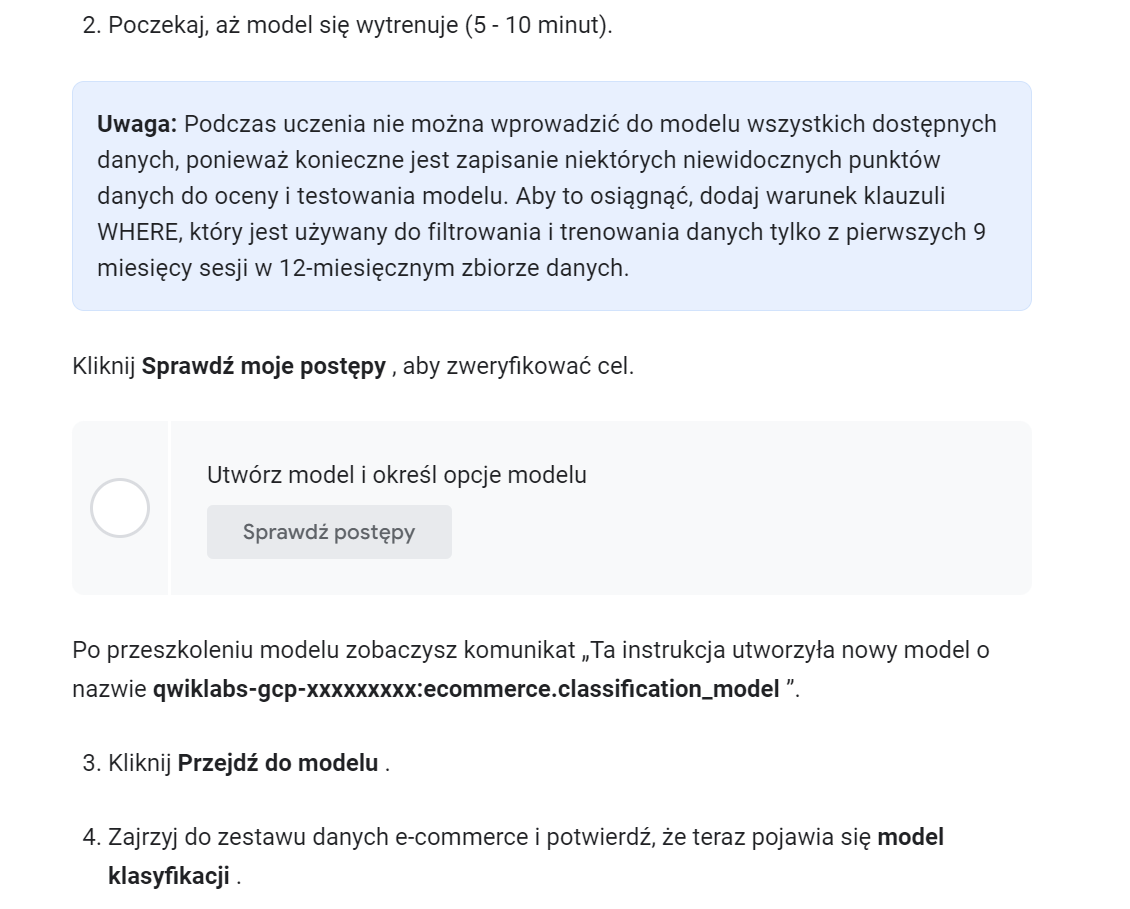

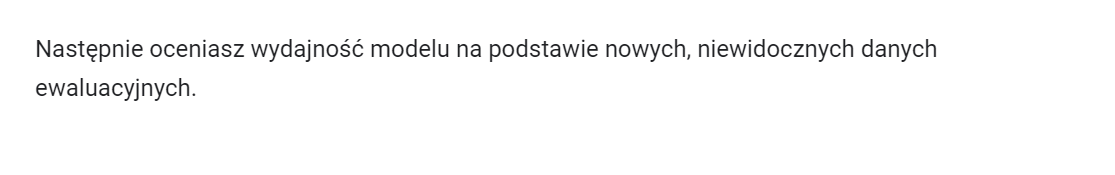

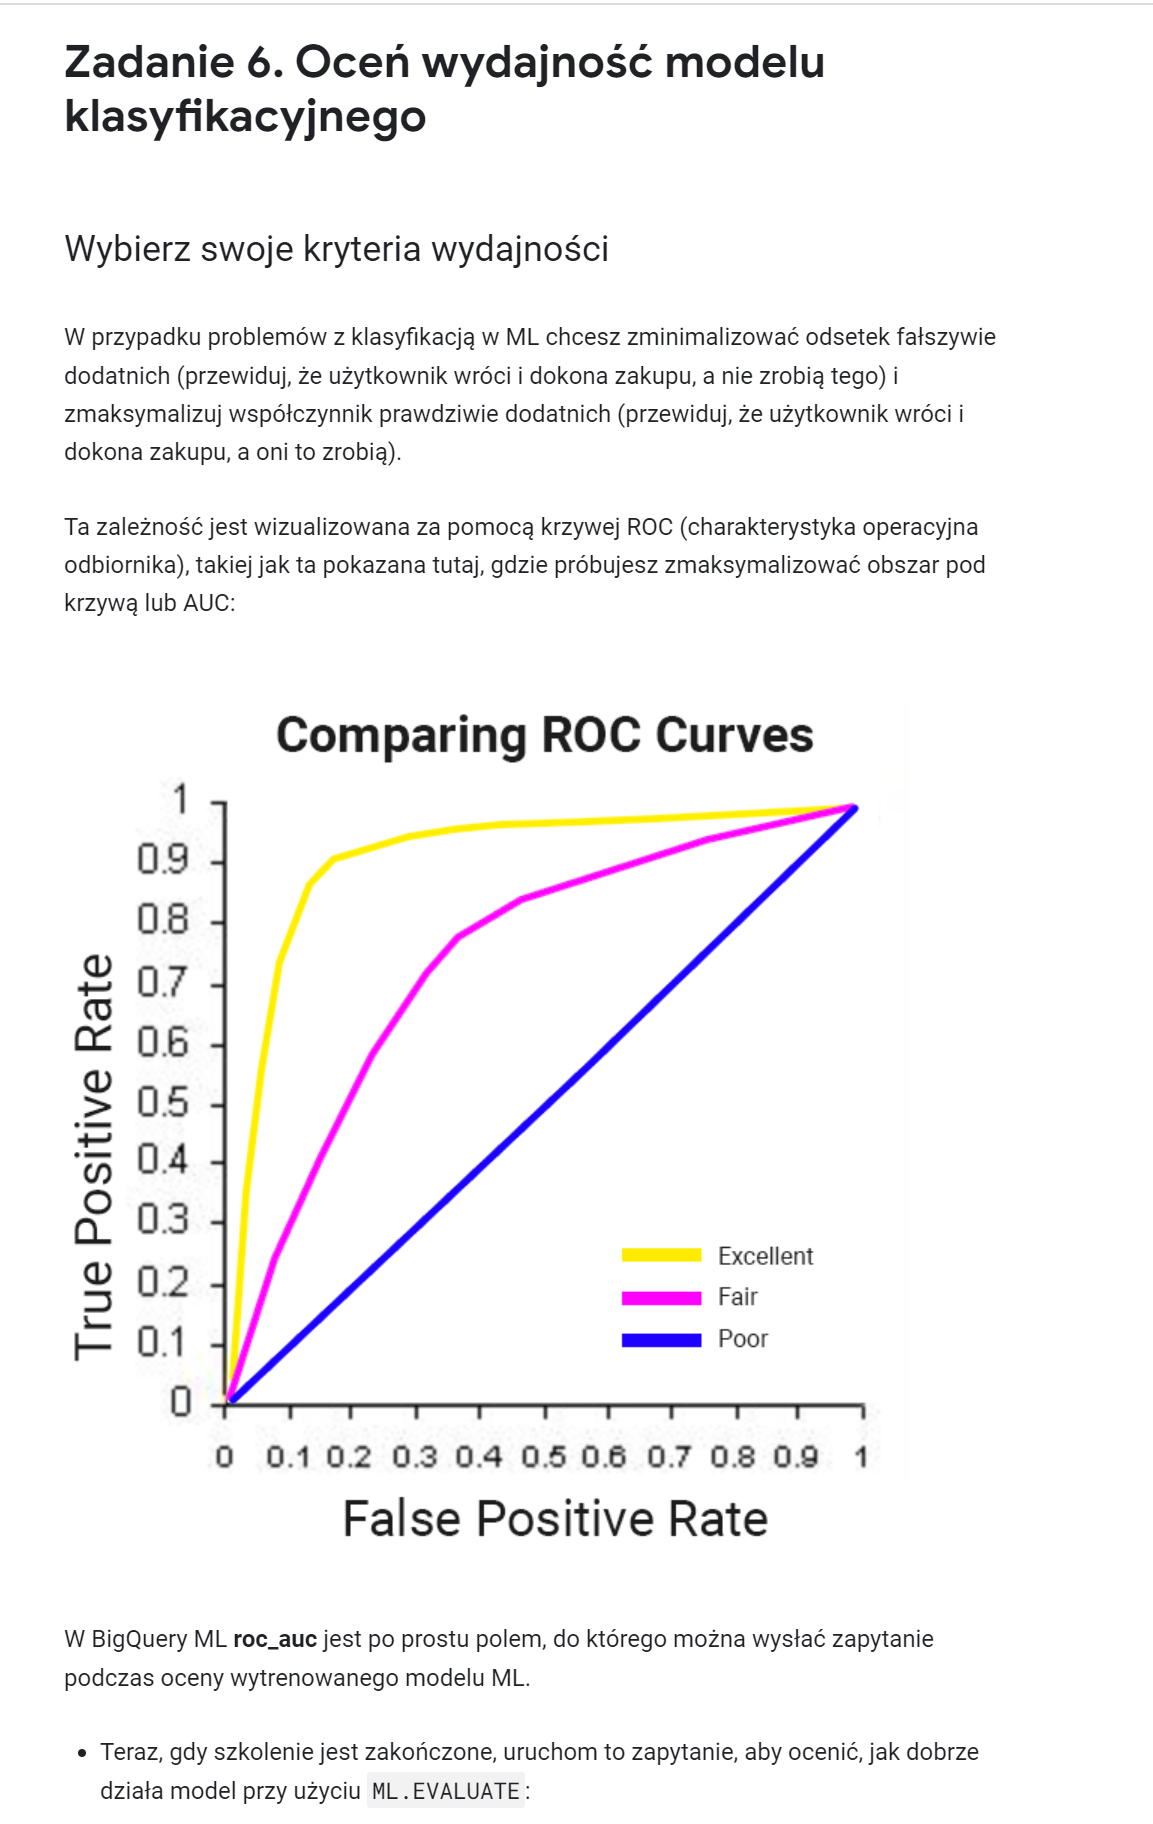

In [ ]:
%%bigquery

SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'decent'
    WHEN roc_auc > .6 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model,  (
SELECT
  * EXCEPT(fullVisitorId)
FROM
  # features
  (SELECT
    fullVisitorId,
    IFNULL(totals.bounces, 0) AS bounces,
    IFNULL(totals.timeOnSite, 0) AS time_on_site
  FROM
    `data-to-insights.ecommerce.web_analytics`
  WHERE
    totals.newVisits = 1

    """Używa zbioru danych do oceny modelu, który jest strukturalnie podobny do zbioru danych użytego do
    trenowania modelu, ale obejmuje inny zakres dat (date BETWEEN '20170501' AND '20170630').
    Jest to ważne dla zapewnienia uczciwej oceny modelu na niezależnym zbiorze danych."""

    AND date BETWEEN '20170501' AND '20170630') # eval on 2 months
  JOIN
  (SELECT
    fullvisitorid,
    IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM
      `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid)
  USING (fullVisitorId)
));

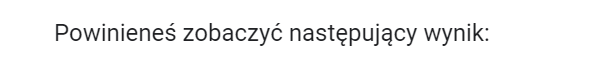

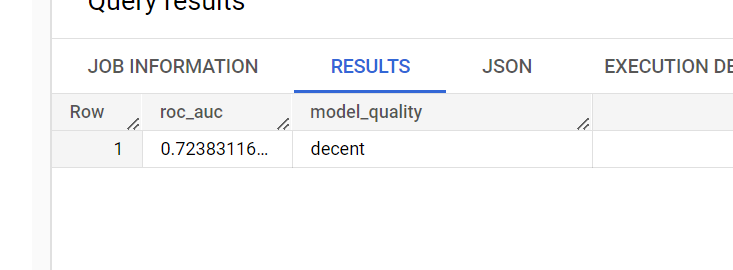

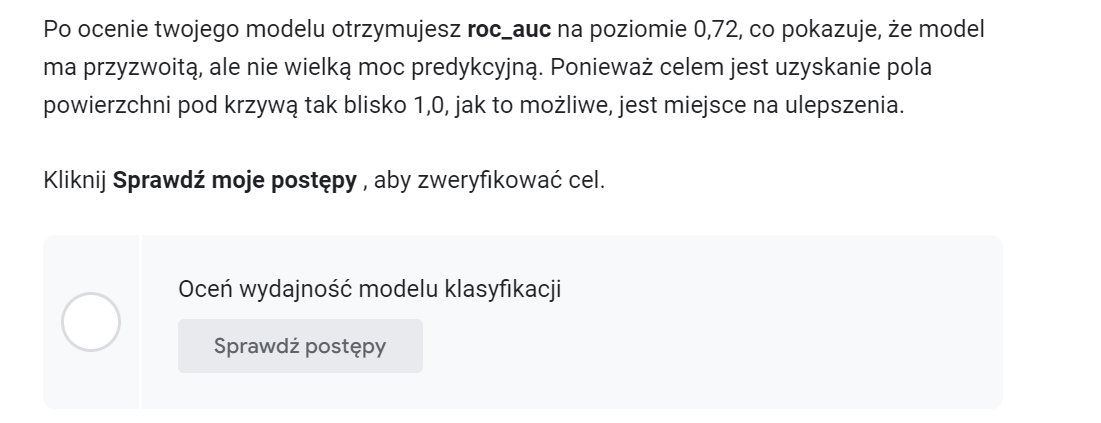

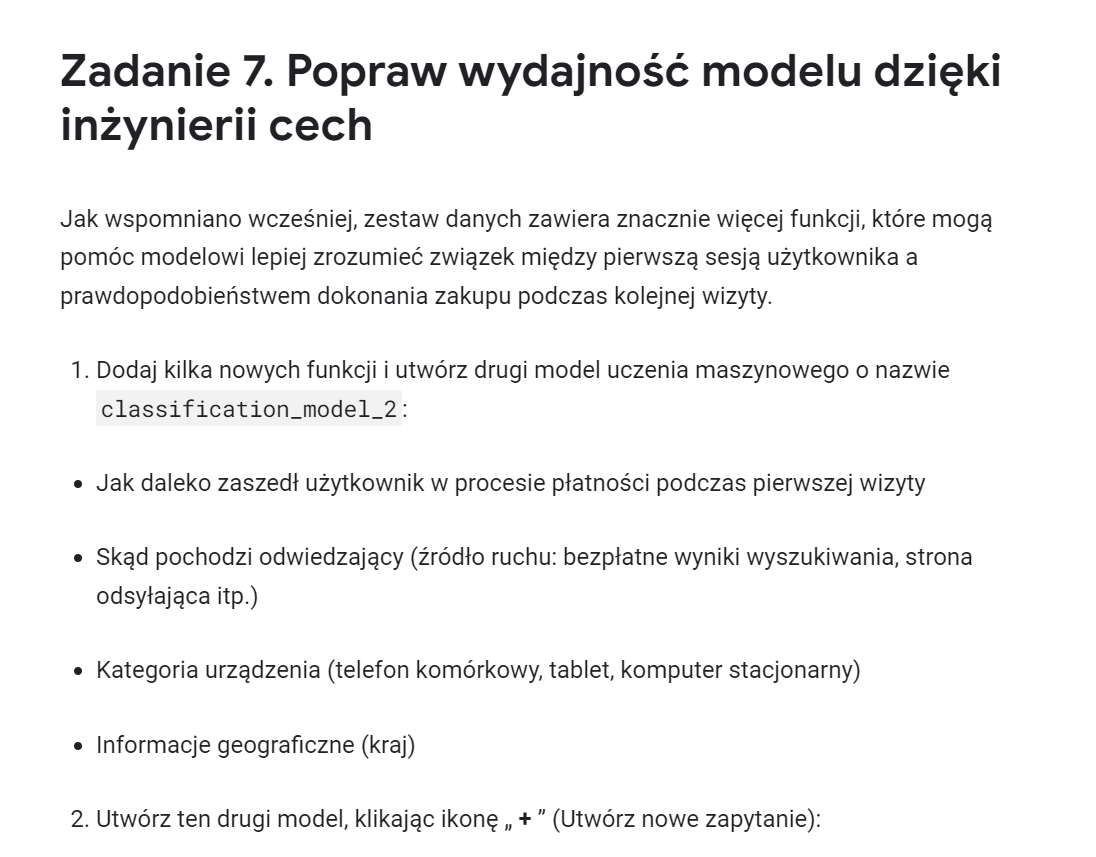

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `ecommerce.classification_model_2`
OPTIONS
  (model_type='logistic_reg', labels = ['will_buy_on_return_visit']) AS
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
# add in new features
SELECT * EXCEPT(unique_session_id) FROM (
  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      IFNULL(totals.pageviews, 0) AS pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20160801' AND '20170430' # train 9 months
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
);

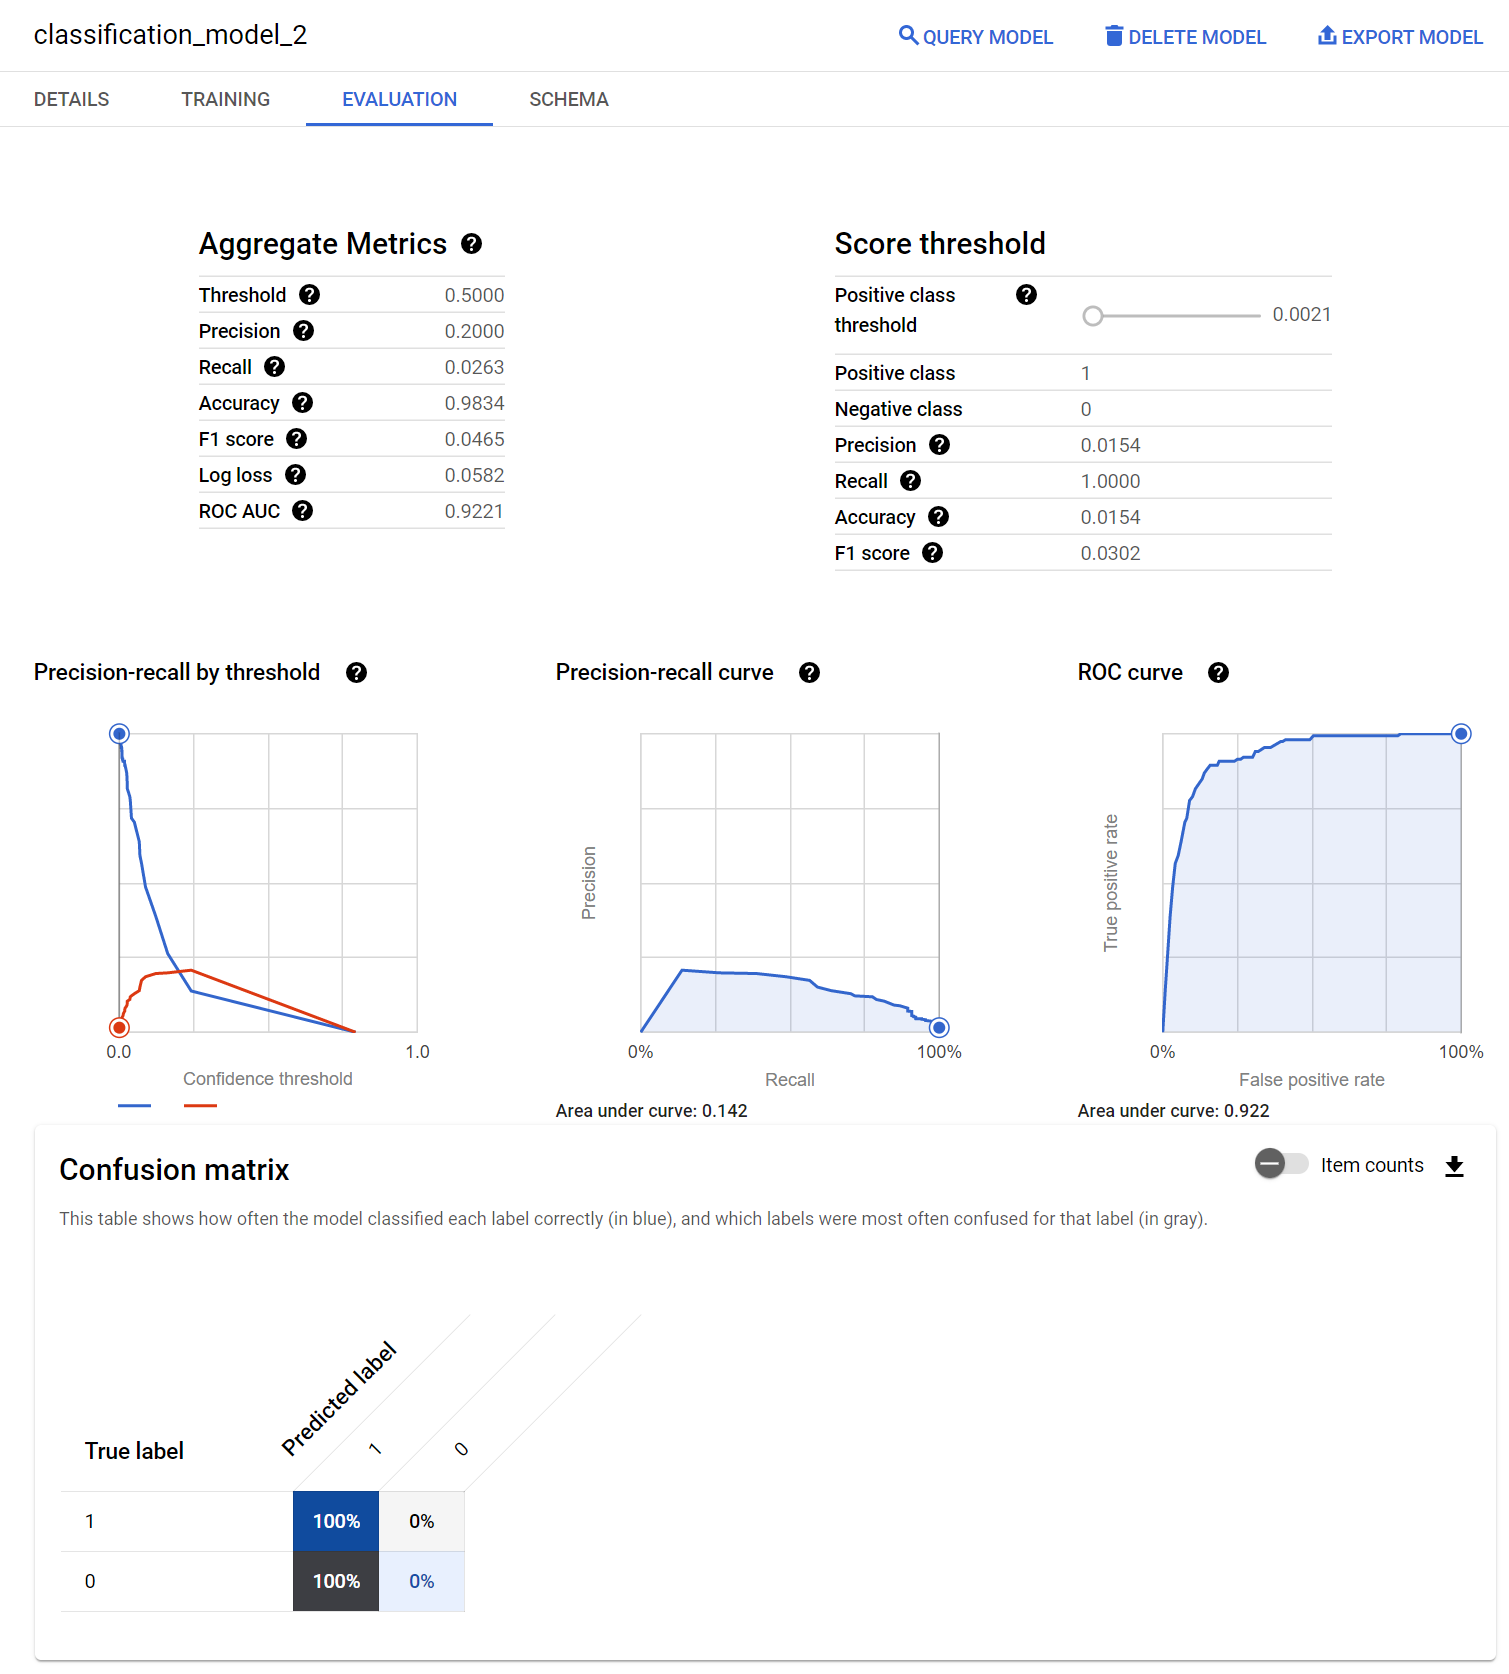

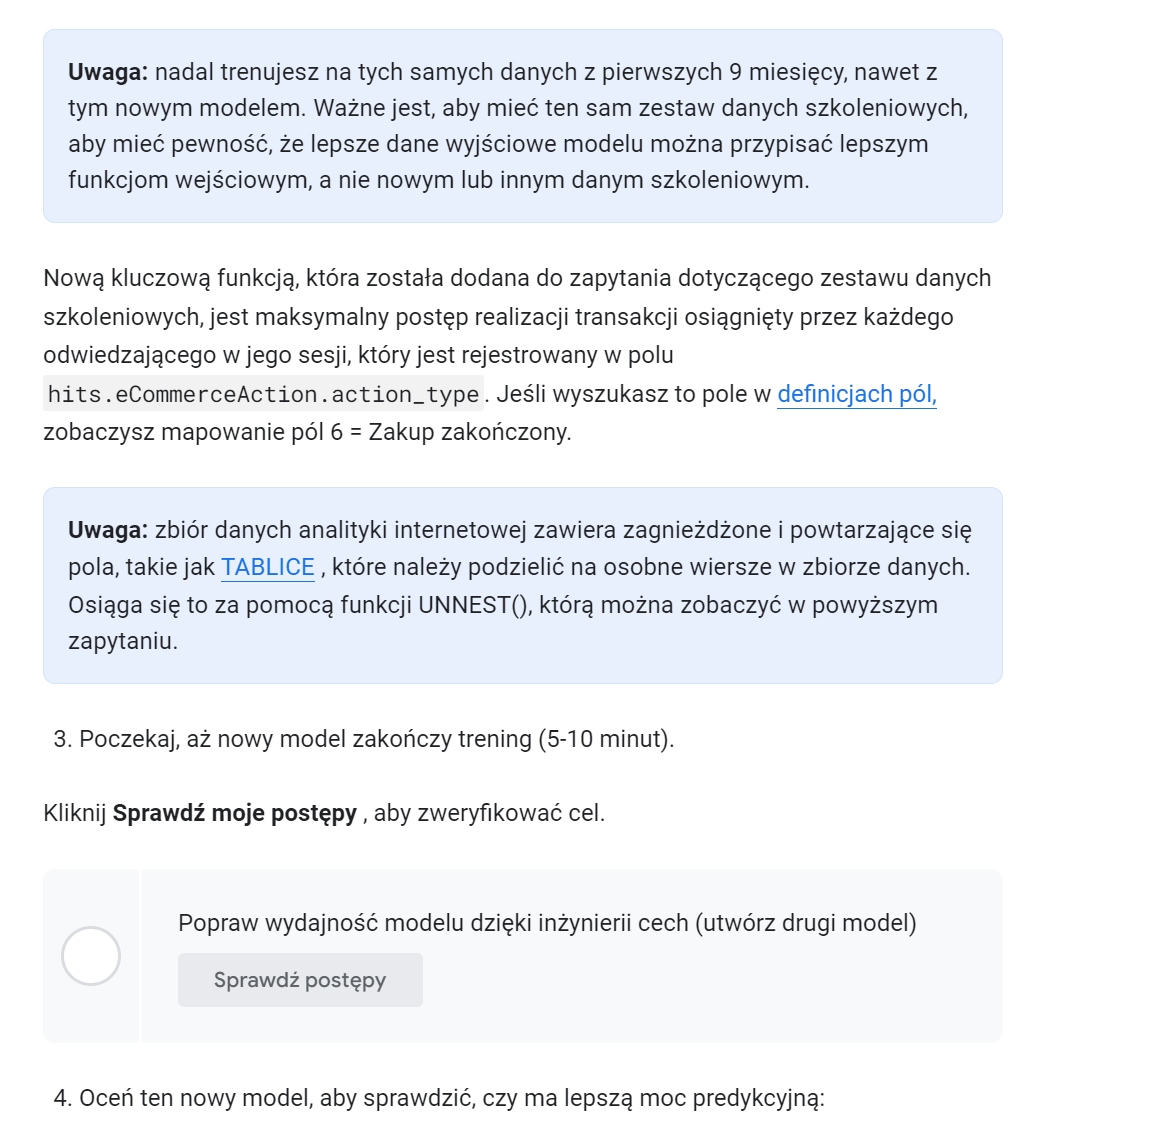

In [ ]:
%%bigquery

SELECT
  roc_auc,
  CASE
    WHEN roc_auc > .9 THEN 'good'
    WHEN roc_auc > .8 THEN 'fair'
    WHEN roc_auc > .7 THEN 'decent'
    WHEN roc_auc > .6 THEN 'not great'
  ELSE 'poor' END AS model_quality
FROM
  ML.EVALUATE(MODEL ecommerce.classification_model_2,  (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
# add in new features
SELECT * EXCEPT(unique_session_id) FROM (
  SELECT
      CONCAT(fullvisitorid, CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE 1=1
    # only predict for new visits
    AND totals.newVisits = 1
    AND date BETWEEN '20170501' AND '20170630' # eval 2 months
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
));

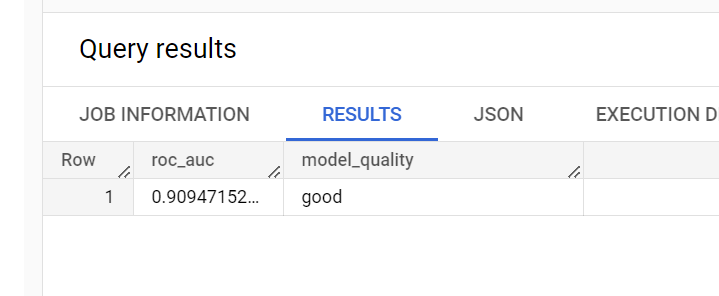

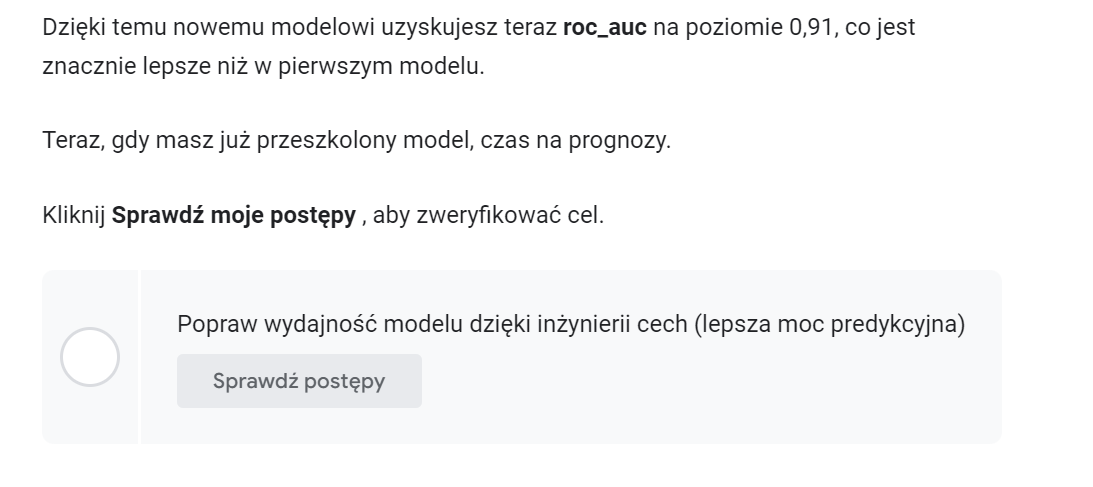

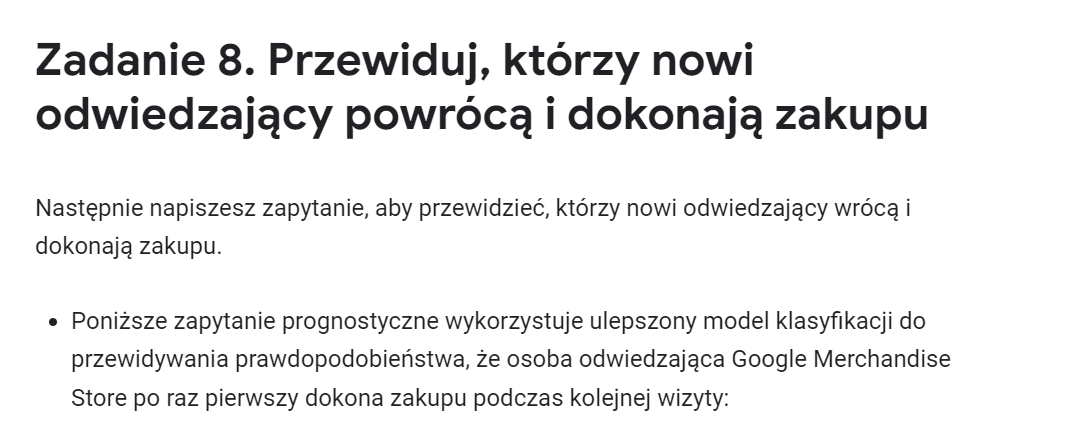

In [ ]:
%%bigquery

SELECT
*
FROM
  ml.PREDICT(MODEL `ecommerce.classification_model_2`,
   (
WITH all_visitor_stats AS (
SELECT
  fullvisitorid,
  IF(COUNTIF(totals.transactions > 0 AND totals.newVisits IS NULL) > 0, 1, 0) AS will_buy_on_return_visit
  FROM `data-to-insights.ecommerce.web_analytics`
  GROUP BY fullvisitorid
)
  SELECT
      CONCAT(fullvisitorid, '-',CAST(visitId AS STRING)) AS unique_session_id,
      # labels
      will_buy_on_return_visit,
      MAX(CAST(h.eCommerceAction.action_type AS INT64)) AS latest_ecommerce_progress,
      # behavior on the site
      IFNULL(totals.bounces, 0) AS bounces,
      IFNULL(totals.timeOnSite, 0) AS time_on_site,
      totals.pageviews,
      # where the visitor came from
      trafficSource.source,
      trafficSource.medium,
      channelGrouping,
      # mobile or desktop
      device.deviceCategory,
      # geographic
      IFNULL(geoNetwork.country, "") AS country
  FROM `data-to-insights.ecommerce.web_analytics`,
     UNNEST(hits) AS h
    JOIN all_visitor_stats USING(fullvisitorid)
  WHERE
    # only predict for new visits
    totals.newVisits = 1
    AND date BETWEEN '20170701' AND '20170801' # test 1 month
  GROUP BY
  unique_session_id,
  will_buy_on_return_visit,
  bounces,
  time_on_site,
  totals.pageviews,
  trafficSource.source,
  trafficSource.medium,
  channelGrouping,
  device.deviceCategory,
  country
)
)
ORDER BY
  predicted_will_buy_on_return_visit DESC;

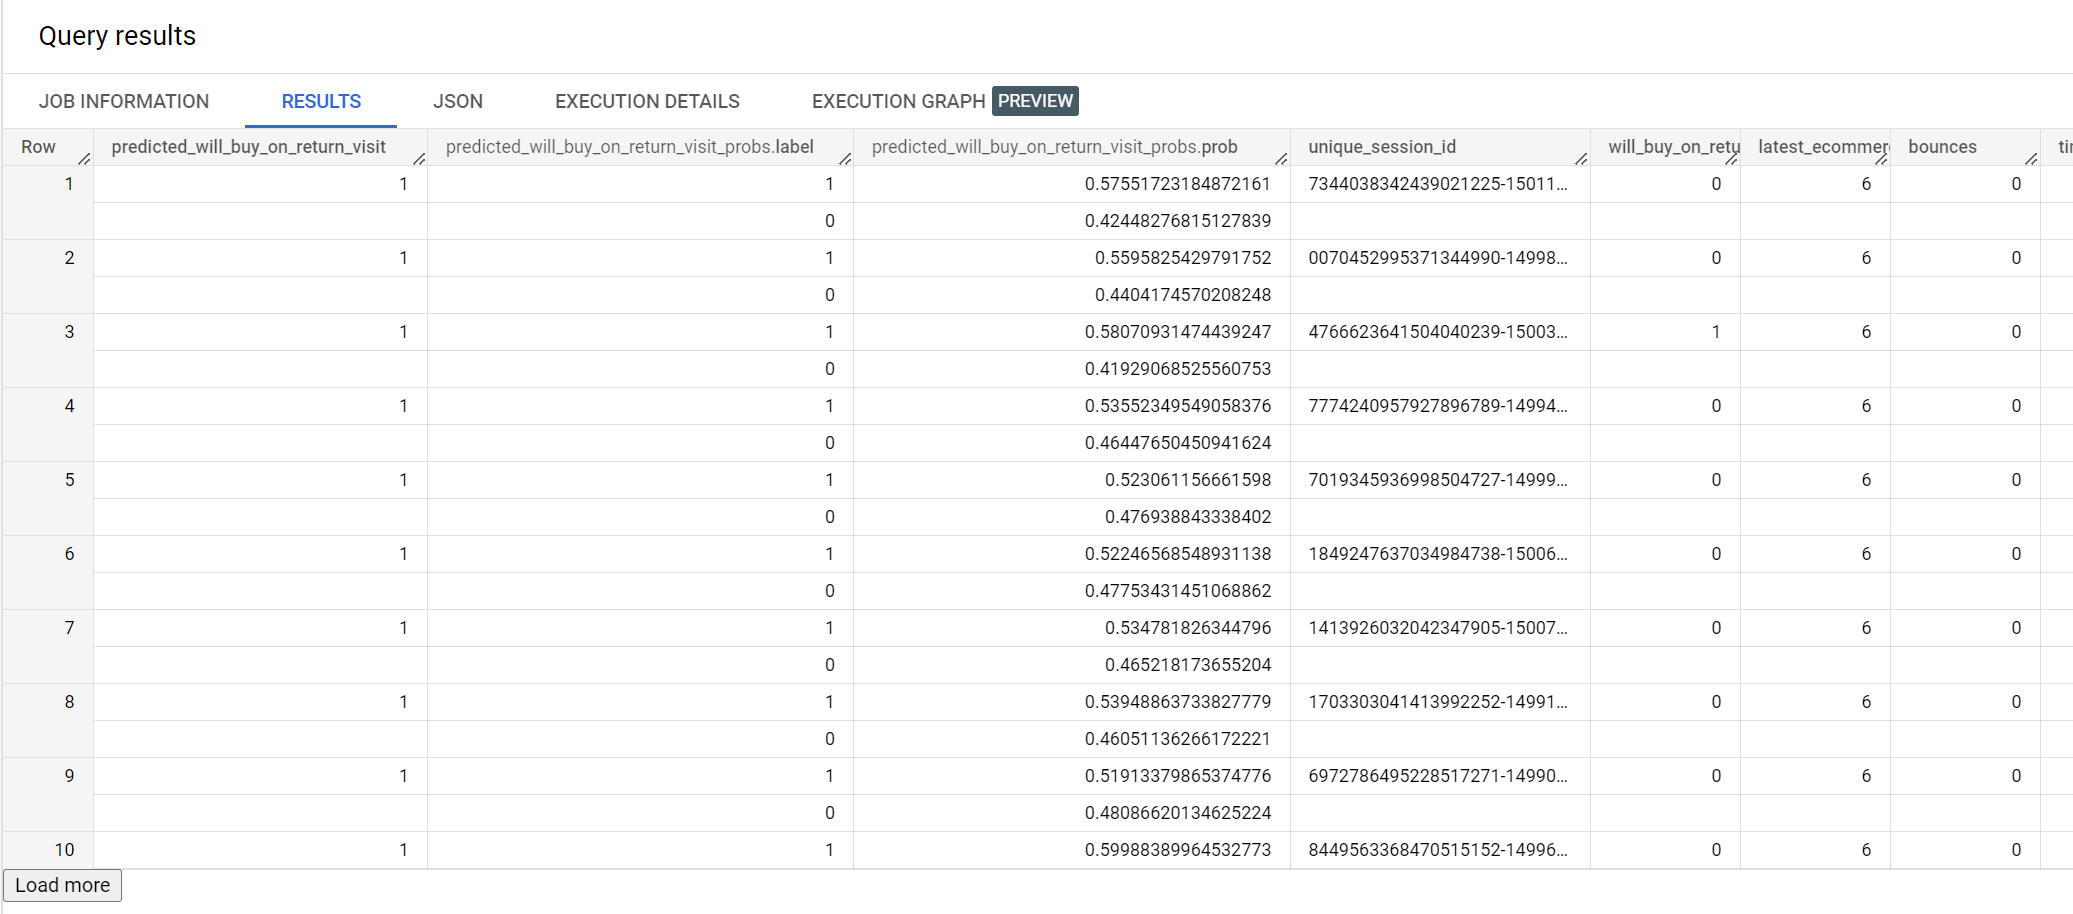

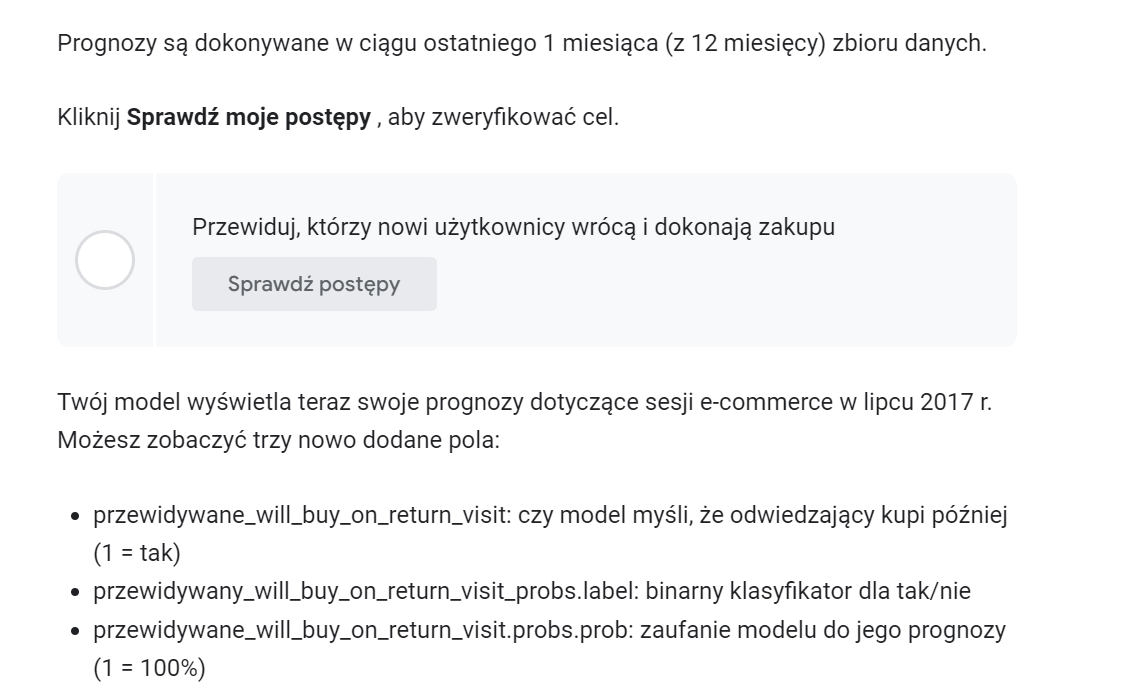

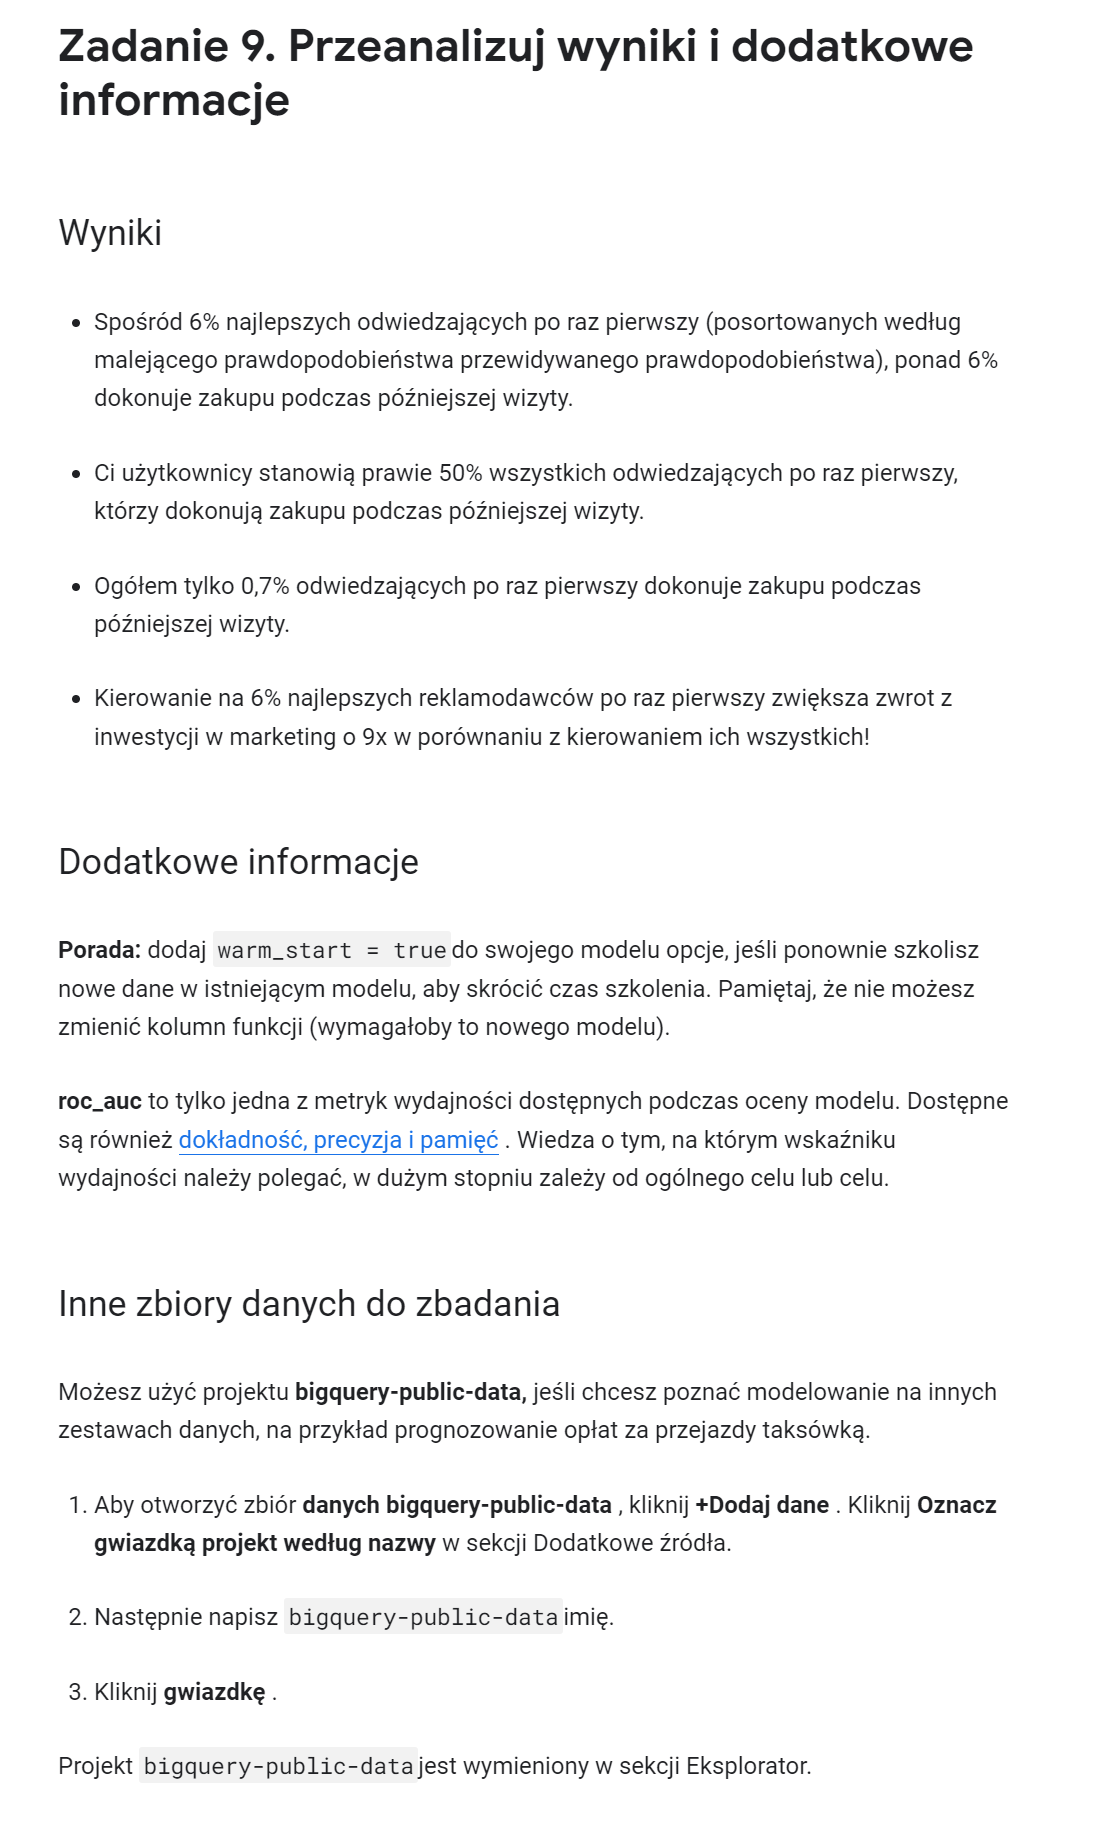